## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

from transformers.models.whisper import WhisperTokenizerFast
from datasets import load_from_disk

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP
from evaluation.string_edit_metrics import get_string_edit_metrics_ortho_and_norm
from normalization.whisper_normalization import get_whisper_normalizer
from utils.whisper_hallucinations.get_features import add_features_to_ds, compute_gzip_compression_ratio
from utils.whisper_hallucinations.eval_filter_criterion import eval_filter_criterion
from utils.notebook_utils import listen_to_audio

sns.set_theme(context="paper", style="ticks")

OUTPUT_DIR = Path("notebooks/outputs/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## Load tokenizer

In [4]:
pretrained_model_name_or_path = "openai/whisper-tiny"
tokenizer = WhisperTokenizerFast.from_pretrained(pretrained_model_name_or_path, language="english", task="transcribe")

## Load dataset

In [5]:
cache_dir = "notebooks/data/librispeech_dummy/whisper-base/k_1"
assert cache_dir, "Please fill `cache_dir`."

ds = load_from_disk(cache_dir)["validation"]

ds

Dataset({
    features: ['audio', 'text', 'input_features', 'labels', 'teacher_sequences', 'token_timestamps'],
    num_rows: 73
})

## Load predictions

In [6]:
# Decode the teacher predicitons
ds = ds.map(lambda x: {"teacher_text": tokenizer.decode(x["teacher_sequences"], skip_special_tokens=True)})

Loading cached processed dataset at /Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models/notebooks/data/librispeech_dummy/whisper-base/k_1/validation/cache-05ca3e5c933e2ae0.arrow


In [7]:
ds["teacher_text"][:3]

[' Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.',
 " Nor is Mr. Quilter's manner less interesting than his matter.",
 ' He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similarly is drawn from eating and its results occur most readily to the mind.']

## Add features to dataset

In [8]:
ds = add_features_to_ds(ds, tokenizer=tokenizer)

ds.features

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'text': Value(dtype='string', id=None),
 'input_features': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'teacher_sequences': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'token_timestamps': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
 'teacher_text': Value(dtype='string', id=None),
 'teacher_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'audio_length': Value(dtype='float32', id=None),
 'n_tokens_labels': Value(dtype='int64', id=None),
 'n_tokens_teacher': Value(dtype='int64', id=None),
 'diff_n_tokens': Value(dtype='int64', id=None),
 'gzip_ratio': Value(dtype='float64', id=None),
 'teacher_gzip_ratio': Value(dtype='float64', id=None),
 'diff_gzip_ratio': Value(dtype='float32', id=None),
 

## Convert to DataFrame

In [9]:
list(ds.features.keys())

['audio',
 'text',
 'input_features',
 'labels',
 'teacher_sequences',
 'token_timestamps',
 'teacher_text',
 'teacher_labels',
 'audio_length',
 'n_tokens_labels',
 'n_tokens_teacher',
 'diff_n_tokens',
 'gzip_ratio',
 'teacher_gzip_ratio',
 'diff_gzip_ratio',
 'n_instant_tokens',
 'max_subarray_length']

In [10]:
LIST_FEATURES = [
    'text',
    'teacher_text',
    'n_instant_tokens',
    'max_subarray_length',
    'audio_length',
    'n_tokens_labels',
    'n_tokens_teacher',
    'diff_n_tokens',
    'gzip_ratio',
    'teacher_gzip_ratio',
    'diff_gzip_ratio'
]

df = pd.DataFrame({col: ds[col] for col in ds.features.keys() if col in LIST_FEATURES})

df.head()

,text,teacher_text,audio_length,n_tokens_labels,n_tokens_teacher,diff_n_tokens,gzip_ratio,teacher_gzip_ratio,diff_gzip_ratio,n_instant_tokens,max_subarray_length
0,mister quilter is the apostle of the middle cl...,Mr. Quilter is the apostle of the middle clas...,5.855000,27,28,1,1.011364,0.946809,-0.064555,3,4
1,nor is mister quilter's manner less interestin...,Nor is Mr. Quilter's manner less interesting ...,4.815000,18,19,1,0.863014,0.805195,-0.057819,3,4
2,he tells us that at this festive season of the...,He tells us that at this festive season of th...,12.485001,47,47,0,1.303030,1.256944,-0.046086,4,5
3,he has grave doubts whether sir frederick leig...,He has graved doubts whether Sir Frederick La...,9.900001,38,33,-5,1.166667,1.072000,-0.094667,4,5
4,linnell's pictures are a sort of up guards and...,Linnell's pictures are a sort of upgards and ...,29.400002,96,97,1,1.553648,1.418327,-0.135321,5,5


## First analysis

In [11]:
dict_string_edit_metrics = get_string_edit_metrics_ortho_and_norm(references=df["text"], predictions=df["teacher_text"], norm_fn=get_whisper_normalizer("english"))

dict_string_edit_metrics

{'WER ortho (%)': 29.652173913043477,
 'Sub ortho (%)': 27.82608695652174,
 'Del ortho (%)': 1.0434782608695654,
 'Ins ortho (%)': 0.782608695652174,
 'WER (%)': 8.212147134302823,
 'Sub (%)': 5.9880239520958085,
 'Del (%)': 1.1120615911035072,
 'Ins (%)': 1.1120615911035072}

**Observation:** Using the Whisper normalizer drastically decreased the different string edit metric errors. Since 1-best operated without any normalization, we will focus on the orthographic WER in this study.

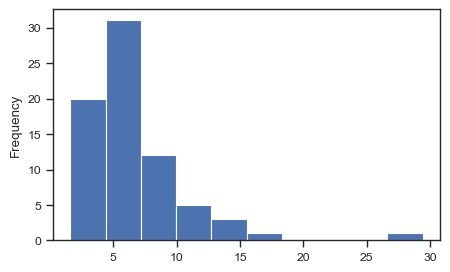

In [12]:
plt.figure(figsize=(5, 3))
df["audio_length"].plot.hist();

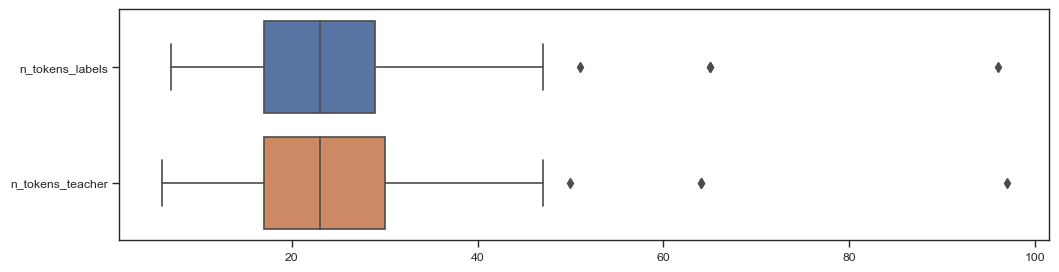

In [13]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=df[["n_tokens_labels", "n_tokens_teacher"]], orient="h");

Figure saved at `notebooks/outputs/text_based/n_diff_tokens/n_tokens_teacher_wrt_n_tokens_label.png`.


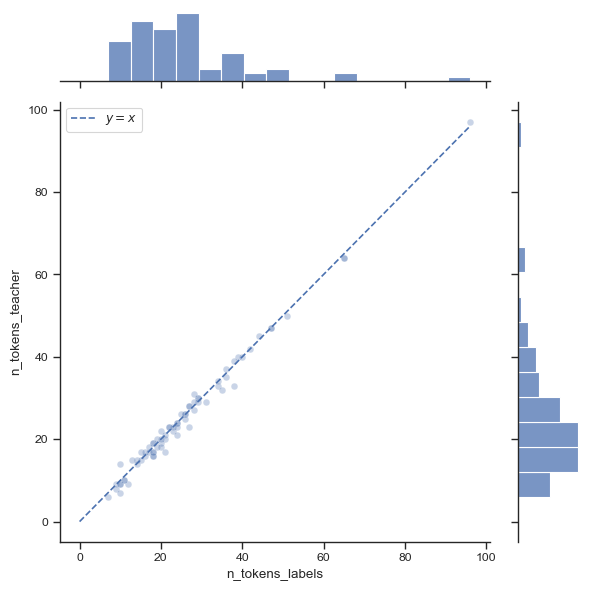

In [14]:
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'b--', label=r"$y=x$")
plt.legend()
plt.tight_layout()

savepath = OUTPUT_DIR / "text_based" / "n_diff_tokens" / "n_tokens_teacher_wrt_n_tokens_label.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

Figure saved at `notebooks/outputs/text_based/n_diff_tokens/boxplot_n_diff_tokens.png`.


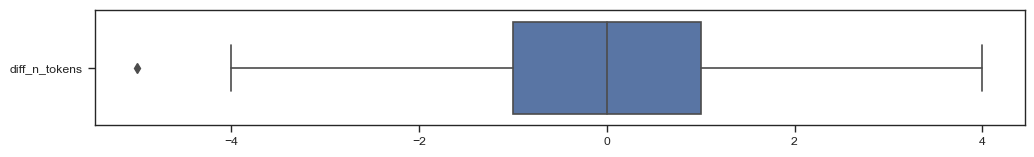

In [15]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")

savepath = OUTPUT_DIR / "text_based" / "n_diff_tokens" / "boxplot_n_diff_tokens.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

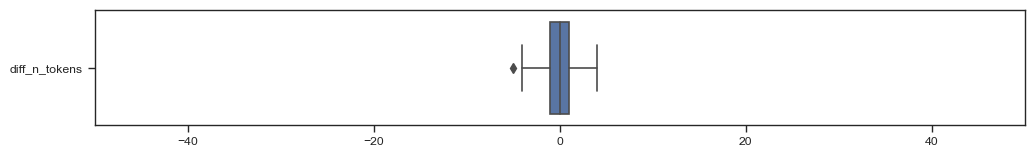

In [16]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")
plt.xlim(-50, 50);

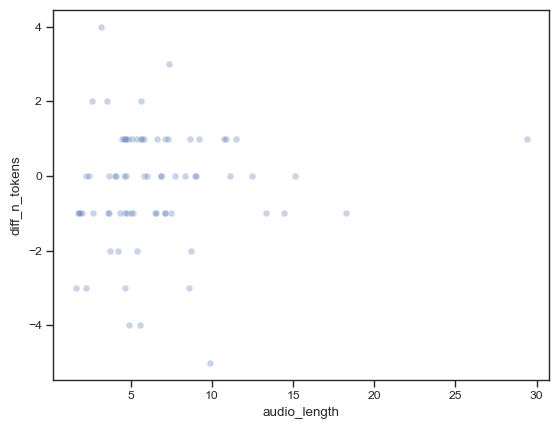

In [17]:
sns.scatterplot(data=df, x="audio_length", y="diff_n_tokens", alpha=0.3);

Figure saved at `notebooks/outputs/preliminary/n_tokens_wrt_audio_length.png`.


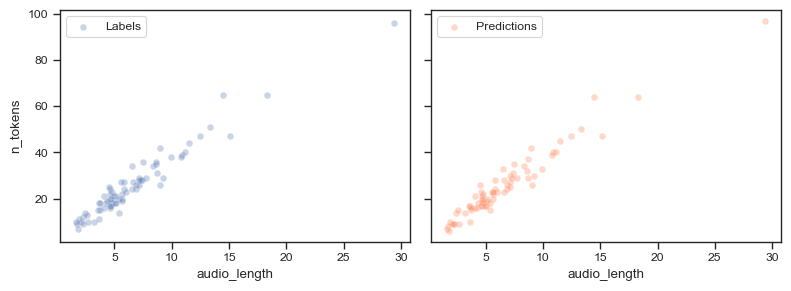

In [18]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="n_tokens_labels", label="Labels", alpha=0.3, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="n_tokens_teacher", label="Predictions", c="coral", alpha=0.3, ax=axis[1])
axis[0].set_ylabel("n_tokens")
fig.tight_layout()

savepath = OUTPUT_DIR / "preliminary" / "n_tokens_wrt_audio_length.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

## Criteria for filtering

### Difference in number of tokens

In [19]:
THRESH_DELTA_N_TOKENS = int(df["diff_n_tokens"].mean() + 1.5 * df["diff_n_tokens"].std())
THRESH_DELTA_N_TOKENS

2

Figure saved at `notebooks/outputs/text_based/n_diff_tokens/n_diff_tokens_filter_pairplot.png`.


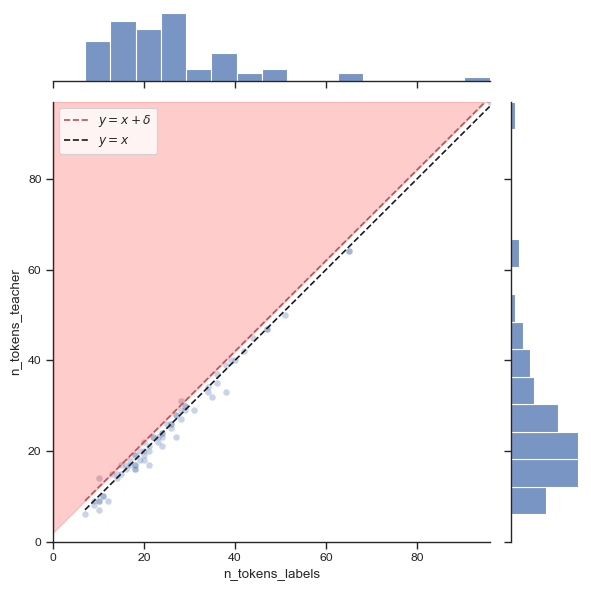

In [20]:
# Define the columns to use for the plot
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

# Define the value of delta
delta = THRESH_DELTA_N_TOKENS

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Add legend and set axis limits
plt.legend()
plt.xlim(0, df[x_col].max())
plt.ylim(0, df[y_col].max())

# Adjust the layout and show the plot
plt.tight_layout()

# Save figure
savepath = OUTPUT_DIR / "text_based" / "n_diff_tokens" / "n_diff_tokens_filter_pairplot.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

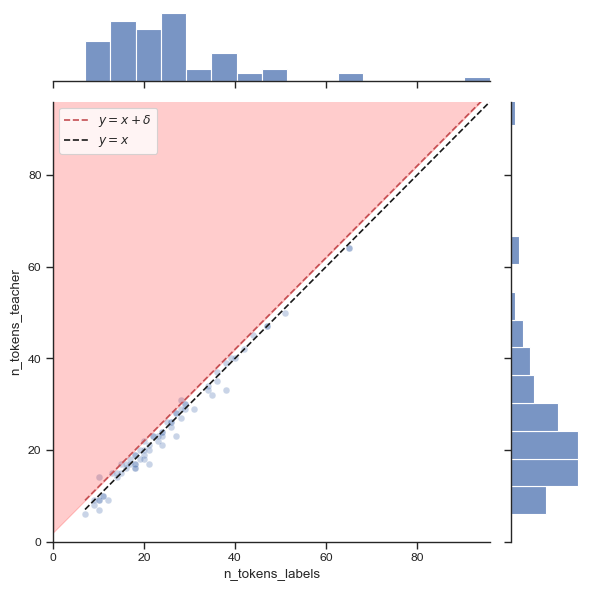

In [21]:
# Define the columns to use for the plot
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

# Define the value of delta
delta = THRESH_DELTA_N_TOKENS

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Add legend and set axis limits
plt.legend()
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.xlim(0, line_max_coord)
plt.ylim(0, line_max_coord)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Figure saved at `notebooks/outputs/text_based/n_diff_tokens/n_diff_tokens_filter_hist.png`.


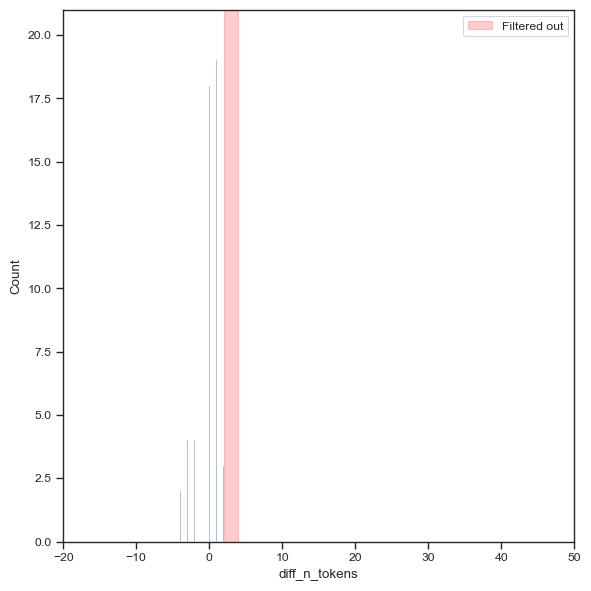

In [22]:
plt.figure(figsize=(6, 6))

# create a histogram of the "diff_n_tokens" column
sns.histplot(data=df, x="diff_n_tokens", bins=100)

# shade the area that will be filtered out in red
plt.axvspan(THRESH_DELTA_N_TOKENS, df["diff_n_tokens"].max(), color='red', alpha=0.2, label="Filtered out")

plt.legend()
plt.xlim(-20, 50)

# show the plot
plt.tight_layout()

# Save figure
savepath = OUTPUT_DIR / "text_based" / "n_diff_tokens" / "n_diff_tokens_filter_hist.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [23]:
df["high_diff_n_tokens"] = (df["diff_n_tokens"] > THRESH_DELTA_N_TOKENS)

df["high_diff_n_tokens"].value_counts()

False    71
True      2
Name: high_diff_n_tokens, dtype: int64

In [24]:
df_candidates = df[df["high_diff_n_tokens"]]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 26
Reference:  not exactly returned kaliko
Prediction:   Not exactly, we've turned Calico.

Idx = 30
Reference:  the metal forest is in the great domed cavern the largest in all our dominions replied kaliko
Prediction:   The middle forest is in the Great Donde Cavern, the largest in all our Dominions, Ripleyed Calico.



In [25]:
list_idx_to_listen = df_candidates.index[:5]

listen_to_audio(ds, list_idx_to_listen, pred_col="teacher_text")

Idx: 26
Reference: not exactly returned kaliko
Prediction:  Not exactly, we've turned Calico.



Idx: 30
Reference: the metal forest is in the great domed cavern the largest in all our dominions replied kaliko
Prediction:  The middle forest is in the Great Donde Cavern, the largest in all our Dominions, Ripleyed Calico.


In [26]:
eval_filter_criterion(ds, filter_fn=lambda x: x["diff_n_tokens"] <= THRESH_DELTA_N_TOKENS)

Filter:   0%|          | 0/73 [00:00<?, ? examples/s]

Number of rows before filtering: 73
Total audio length before filtering: 8.02 minutes
String edit metrics before filtering:
{'Del (%)': 1.11,
 'Del ortho (%)': 1.04,
 'Ins (%)': 1.11,
 'Ins ortho (%)': 0.78,
 'Sub (%)': 5.99,
 'Sub ortho (%)': 27.83,
 'WER (%)': 8.21,
 'WER ortho (%)': 29.65}

Number of rows after filtering: 71
Total audio length after filtering: 7.84 minutes
String edit metrics after filtering:
{'Del (%)': 1.13,
 'Del ortho (%)': 1.06,
 'Ins (%)': 0.96,
 'Ins ortho (%)': 0.71,
 'Sub (%)': 5.57,
 'Sub ortho (%)': 27.28,
 'WER (%)': 7.67,
 'WER ortho (%)': 29.05}

Number of rows removed: 2 (2.74 %)
Total audio length removed: 0.18 minutes (2.19 %)
String edit metrics difference:
{'Del (%)': -0.02,
 'Del ortho (%)': -0.02,
 'Ins (%)': 0.15,
 'Ins ortho (%)': 0.07,
 'Sub (%)': 0.42,
 'Sub ortho (%)': 0.55,
 'WER (%)': 0.54,
 'WER ortho (%)': 0.6}

Relative string edit metrics difference:
{'Del (%)': -0.02,
 'Del ortho (%)': -0.02,
 'Ins (%)': 0.14,
 'Ins ortho (%)': 0.09,

**Observation:** Good criterion. Note that this also tackles the fact that the vanilla Whisper models tend to transcribe even the speeches in the background. By removing them from the training set, we hope to teach Whisper to only focus on the main speaker.

### gzip compression ratio

In [27]:
# Quick example to confirm the intuition:
ref = "yeah so uh what we'll do is uh"
pred = "So, what we will do is, we will do is, we will do is, we will do is, we will do is,"

print("gzip ratios:")
print("- reference: ", compute_gzip_compression_ratio(ref))
print("- prediction: ", compute_gzip_compression_ratio(pred))

gzip ratios:
- reference:  0.6122448979591837
- prediction:  1.8444444444444446


In [28]:
df.columns

Index(['text', 'teacher_text', 'audio_length', 'n_tokens_labels',
       'n_tokens_teacher', 'diff_n_tokens', 'gzip_ratio', 'teacher_gzip_ratio',
       'diff_gzip_ratio', 'n_instant_tokens', 'max_subarray_length',
       'high_diff_n_tokens'],
      dtype='object')

Figure saved at `notebooks/outputs/text_based/gzip_ratio/pairplot_gzip.png`.


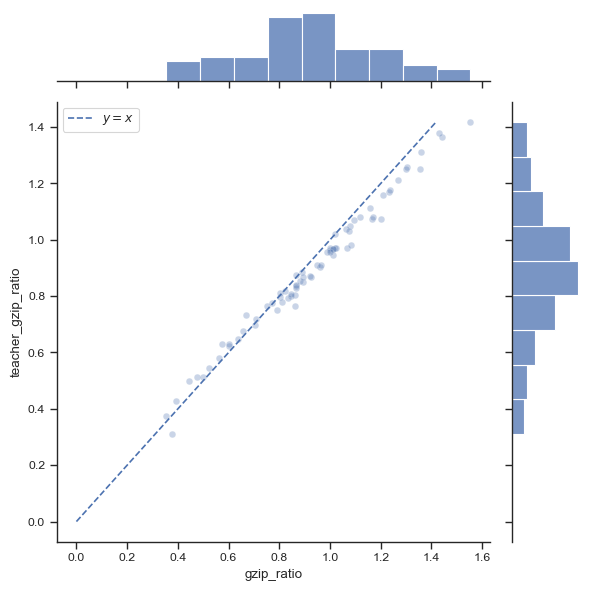

In [29]:
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'b--', label=r"$y=x$")
plt.legend()
# plt.xlim(-1, line_max_coord)
# plt.ylim(-1, line_max_coord)
plt.tight_layout()

savepath = OUTPUT_DIR / "text_based" / "gzip_ratio" / "pairplot_gzip.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

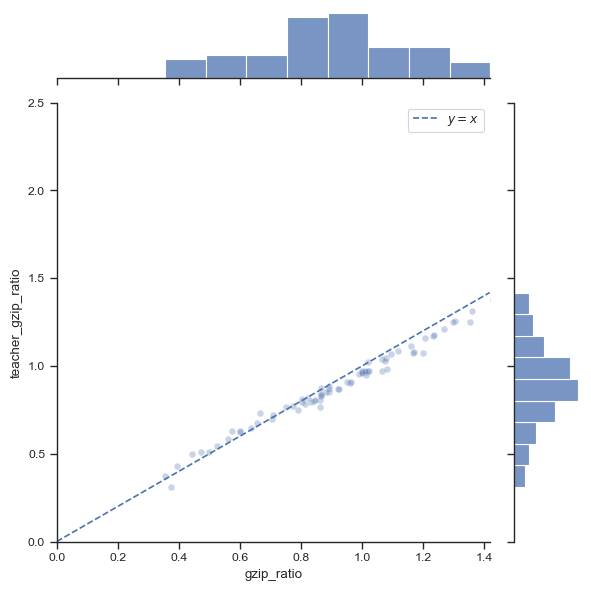

In [30]:
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'b--', label=r"$y=x$")
plt.legend()
plt.xlim(0, line_max_coord)
plt.ylim(0, 2.5)
plt.tight_layout()

Figure saved at `notebooks/outputs/text_based/gzip_ratio/boxplot_gzip_ratio.png`.


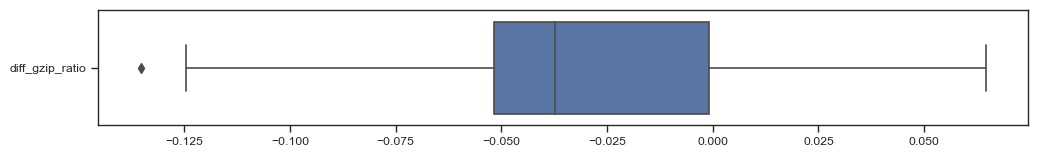

In [31]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_gzip_ratio"]], orient="h")

# Save figure:
savepath = OUTPUT_DIR / "text_based" / "gzip_ratio" / "boxplot_gzip_ratio.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [32]:
THRESH_DIFF_GZIP = df["diff_gzip_ratio"].mean() + 1.5 * df["diff_gzip_ratio"].std()

THRESH_DIFF_GZIP

0.03136839531362057

Figure saved at `notebooks/outputs/text_based/gzip_ratio/pairplot_gzip_filter.png`.


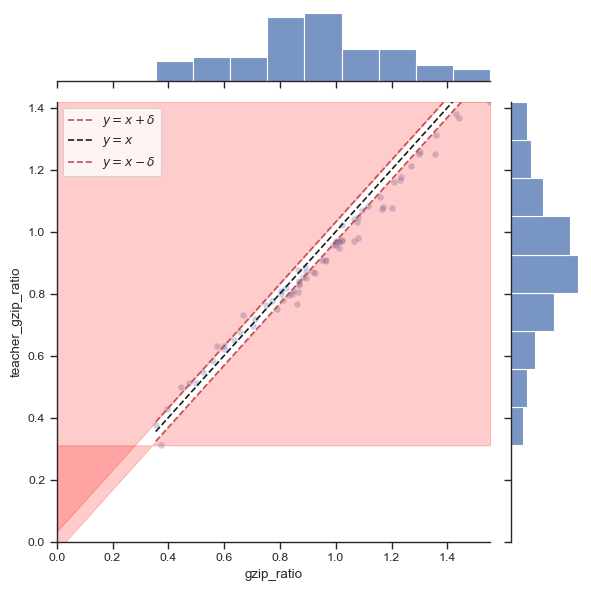

In [33]:
# Define the columns to use for the plot
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"


# Define the value of delta
delta = THRESH_DIFF_GZIP

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Plot the line y = x - delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() - delta, df[x_col].max() - delta], 'r--', label=r"$y = x - \delta$")

# Fill the area below the line y = x - delta
plt.fill_between([0, df[x_col].max()],
                 [0 - delta, df[x_col].max() - delta], df[y_col].min(),
                 alpha=0.2,
                 color="red")

# Add legend and set axis limits
plt.legend()
plt.xlim(0, df[x_col].max())
plt.ylim(0, df[y_col].max())

# Adjust the layout and show the plot
plt.tight_layout()

# Save figure:
savepath = OUTPUT_DIR / "text_based" / "gzip_ratio" / "pairplot_gzip_filter.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

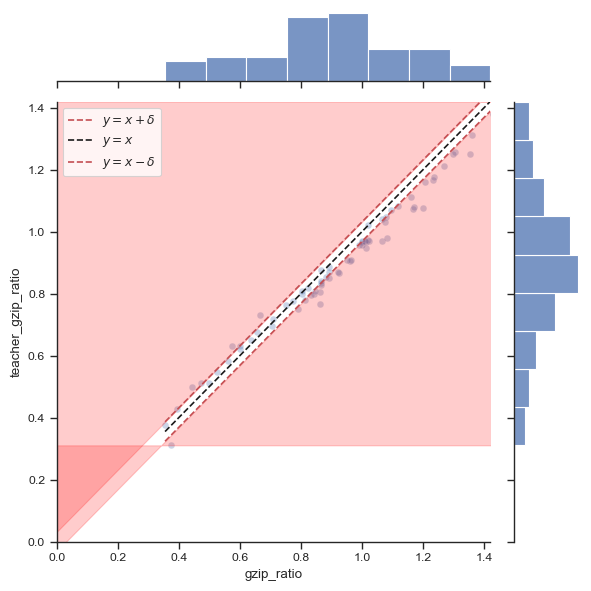

In [34]:
# Define the columns to use for the plot
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"


# Define the value of delta
delta = THRESH_DIFF_GZIP

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Plot the line y = x - delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() - delta, df[x_col].max() - delta], 'r--', label=r"$y = x - \delta$")

# Fill the area below the line y = x - delta
plt.fill_between([0, df[x_col].max()],
                 [0 - delta, df[x_col].max() - delta], df[y_col].min(),
                 alpha=0.2,
                 color="red")

# Add legend and set axis limits
plt.legend()
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.xlim(0, line_max_coord)
plt.ylim(0, line_max_coord)

# Adjust the layout and show the plot
plt.tight_layout()

Figure saved at `notebooks/outputs/text_based/gzip_ratio/hist_gzip_filter.png`.


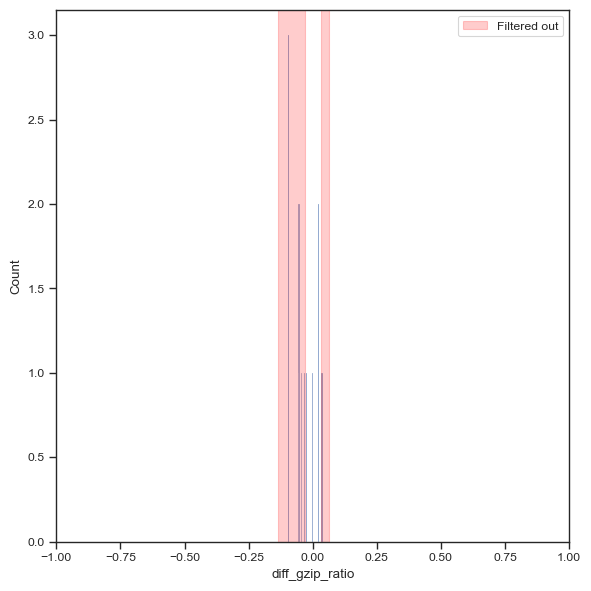

In [35]:
plt.figure(figsize=(6, 6))

# create a histogram of the "diff_n_tokens" column
sns.histplot(data=df, x="diff_gzip_ratio", bins=200)

# shade the area that will be filtered out in red
plt.axvspan(THRESH_DIFF_GZIP, df["diff_gzip_ratio"].max(), color='red', alpha=0.2, label="Filtered out")
plt.axvspan(-THRESH_DIFF_GZIP, df["diff_gzip_ratio"].min(), color='red', alpha=0.2)

plt.legend()
plt.xlim(-1, 1)

# show the plot
plt.tight_layout()

# Save figure:
savepath = OUTPUT_DIR / "text_based" / "gzip_ratio" / "hist_gzip_filter.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [36]:
df_candidates = df[df["diff_gzip_ratio"] > THRESH_DIFF_GZIP]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 26
Reference:  not exactly returned kaliko
Prediction:   Not exactly, we've turned Calico.

Idx = 29
Reference:  where is that
Prediction:   Where is that?

Idx = 31
Reference:  kaliko hesitated
Prediction:   Callergo hesitated.

Idx = 34
Reference:  that's funny remarked betsy thoughtfully
Prediction:   That's funny, remarked the bedside thoughtfully.

Idx = 37
Reference:  true agreed kaliko
Prediction:   True, agreed Calico.



In [37]:
df_candidates = df[df["diff_gzip_ratio"] < - THRESH_DIFF_GZIP]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 0
Reference:  mister quilter is the apostle of the middle classes and we are glad to welcome his gospel
Prediction:   Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.

Idx = 1
Reference:  nor is mister quilter's manner less interesting than his matter
Prediction:   Nor is Mr. Quilter's manner less interesting than his matter.

Idx = 2
Reference:  he tells us that at this festive season of the year with christmas and roast beef looming before us similes drawn from eating and its results occur most readily to the mind
Prediction:   He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similarly is drawn from eating and its results occur most readily to the mind.

Idx = 3
Reference:  he has grave doubts whether sir frederick leighton's work is really greek after all and can discover in it but little of rocky ithaca
Prediction:   He has graved doubts whether Sir Frederick Layton's work is really G

In [38]:
eval_filter_criterion(ds, filter_fn=lambda x: np.abs(x["diff_gzip_ratio"]) <= THRESH_DIFF_GZIP)

Filter:   0%|          | 0/73 [00:00<?, ? examples/s]

Number of rows before filtering: 73
Total audio length before filtering: 8.02 minutes
String edit metrics before filtering:
{'Del (%)': 1.11,
 'Del ortho (%)': 1.04,
 'Ins (%)': 1.11,
 'Ins ortho (%)': 0.78,
 'Sub (%)': 5.99,
 'Sub ortho (%)': 27.83,
 'WER (%)': 8.21,
 'WER ortho (%)': 29.65}

Number of rows after filtering: 26
Total audio length after filtering: 1.93 minutes
String edit metrics after filtering:
{'Del (%)': 1.08,
 'Del ortho (%)': 1.11,
 'Ins (%)': 2.53,
 'Ins ortho (%)': 1.85,
 'Sub (%)': 7.22,
 'Sub ortho (%)': 32.96,
 'WER (%)': 10.83,
 'WER ortho (%)': 35.93}

Number of rows removed: 47 (64.38 %)
Total audio length removed: 6.09 minutes (75.94 %)
String edit metrics difference:
{'Del (%)': 0.03,
 'Del ortho (%)': -0.07,
 'Ins (%)': -1.42,
 'Ins ortho (%)': -1.07,
 'Sub (%)': -1.23,
 'Sub ortho (%)': -5.13,
 'WER (%)': -2.62,
 'WER ortho (%)': -6.28}

Relative string edit metrics difference:
{'Del (%)': 0.03,
 'Del ortho (%)': -0.07,
 'Ins (%)': -1.28,
 'Ins ortho (

### Timestamp overlaps

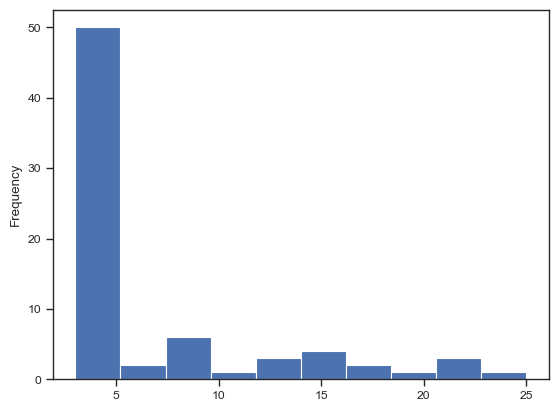

In [39]:
df["n_instant_tokens"].plot.hist();

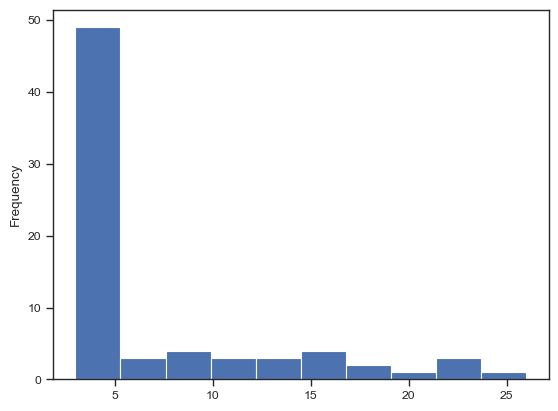

In [40]:
df["max_subarray_length"].plot.hist();

In [41]:
ds_candidate = ds.filter(lambda x: x["n_instant_tokens"] > 20)

for idx, row in enumerate(ds_candidate):
    print("Index: ", idx)
    print("Reference: ", row["text"])
    print("Pred: ", row["teacher_text"])
    print()

Filter:   0%|          | 0/73 [00:00<?, ? examples/s]

Index:  0
Reference:  breathing deeply brion softly spoke the auto hypnotic phrases that triggered the process
Pred:   Breathing deeply, Briann's softly spoke the auto hypnotic phrases that triggered the process.

Index:  1
Reference:  when the buzzer sounded he pulled his foil from his second's startled grasp and ran forward
Pred:   When the buzzer sounded, he pulled his foil from his second startled grasp and ran forward.

Index:  2
Reference:  he thought it was a last burst of energy he knew how close they both were to exhaustion
Pred:   He said it was the last burst of energy. He knew how close they both were to exhaustion.

Index:  3
Reference:  a wave of despair rolled out from irolg brion sensed it and knew the fifth point was his
Pred:   A wave of despair rolled out from Irolgg. Brian sensed it and knew the fifth point was his.



In [42]:
ds_candidate = ds.filter(lambda x: x["max_subarray_length"] > 20)

for idx, row in enumerate(ds_candidate):
    print("Index: ", idx)
    print("Reference: ", row["text"])
    print("Pred: ", row["teacher_text"])
    print()

Filter:   0%|          | 0/73 [00:00<?, ? examples/s]

Index:  0
Reference:  breathing deeply brion softly spoke the auto hypnotic phrases that triggered the process
Pred:   Breathing deeply, Briann's softly spoke the auto hypnotic phrases that triggered the process.

Index:  1
Reference:  when the buzzer sounded he pulled his foil from his second's startled grasp and ran forward
Pred:   When the buzzer sounded, he pulled his foil from his second startled grasp and ran forward.

Index:  2
Reference:  he thought it was a last burst of energy he knew how close they both were to exhaustion
Pred:   He said it was the last burst of energy. He knew how close they both were to exhaustion.

Index:  3
Reference:  a wave of despair rolled out from irolg brion sensed it and knew the fifth point was his
Pred:   A wave of despair rolled out from Irolgg. Brian sensed it and knew the fifth point was his.



In [43]:
eval_filter_criterion(ds, filter_fn=lambda x: x["n_instant_tokens"] <= 20)

Filter:   0%|          | 0/73 [00:00<?, ? examples/s]

Number of rows before filtering: 73
Total audio length before filtering: 8.02 minutes
String edit metrics before filtering:
{'Del (%)': 1.11,
 'Del ortho (%)': 1.04,
 'Ins (%)': 1.11,
 'Ins ortho (%)': 0.78,
 'Sub (%)': 5.99,
 'Sub ortho (%)': 27.83,
 'WER (%)': 8.21,
 'WER ortho (%)': 29.65}

Number of rows after filtering: 69
Total audio length after filtering: 7.56 minutes
String edit metrics after filtering:
{'Del (%)': 1.09,
 'Del ortho (%)': 1.11,
 'Ins (%)': 1.09,
 'Ins ortho (%)': 0.83,
 'Sub (%)': 5.89,
 'Sub ortho (%)': 27.83,
 'WER (%)': 8.07,
 'WER ortho (%)': 29.77}

Number of rows removed: 4 (5.48 %)
Total audio length removed: 0.45 minutes (5.65 %)
String edit metrics difference:
{'Del (%)': 0.02,
 'Del ortho (%)': -0.07,
 'Ins (%)': 0.02,
 'Ins ortho (%)': -0.05,
 'Sub (%)': 0.1,
 'Sub ortho (%)': 0.0,
 'WER (%)': 0.14,
 'WER ortho (%)': -0.12}

Relative string edit metrics difference:
{'Del (%)': 0.02,
 'Del ortho (%)': -0.07,
 'Ins (%)': 0.02,
 'Ins ortho (%)': -0.06,